In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
from IPython.display import Image
warnings.filterwarnings('ignore')

(60000, 28, 28)
(10000, 28, 28)
uint8
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   3  18  18  18 126 136
  175  26 166 255 247 127   0   0   0   0]
 [  0   0   0   0   0   0   0   0  30  36  94 154 170 253 253 253 253 253
  225 172 253 242 195  64   0   0   0   0]
 [  0   0   0   0   0   0   0  49 238 253 253 253 253 253 253 253 253 251
   93  82  82  56  39   0   0   0   0   0]
 [  0   0   0   0   0   0 

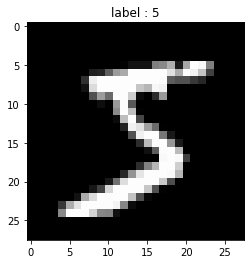

1.0
0.0
(60000,)
(60000, 10)
float64
(48000, 784)
(12000, 784)
(48000,)
(12000,)
(48000, 10)
(12000, 10)


In [2]:
# MNISTデータをmodel入力用に整形
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()
print(X_train.shape) # (60000, 28, 28)
print(X_test.shape) # (10000, 28, 28)
print(X_train[0].dtype) # uint8
print(X_train[0])
# 1次元にする
X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)

# 一つ可視化
import matplotlib.pyplot as plt
%matplotlib inline
index = 0
image = X_train[index].reshape(28,28)
# X_train[index]: (784,)
# image: (28, 28)
plt.imshow(image, 'gray')
plt.title('label : {}'.format(y_train[index]))
plt.show()

# scaleを0 ~ 255から0 ~ 1にする
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255
print(X_train.max()) # 1.0
print(X_train.min()) # 0.0

# OHE作成
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_test_one_hot = enc.transform(y_test[:, np.newaxis])
print(y_train.shape) # (60000,)
print(y_train_one_hot.shape) # (60000, 10)
print(y_train_one_hot.dtype) # float64

# トレーニングとテストデータに分割
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)
print(X_train.shape) # (48000, 784)
print(X_val.shape) # (12000, 784)
print(y_train.shape) # (12000, 784)
print(y_val.shape) # (12000, 784)

# 分割後のyにOHE適用
y_train = enc.transform(y_train[:, np.newaxis])
y_val = enc.transform(y_val[:, np.newaxis])
print(np.shape(y_train))
print(np.shape(y_val))

In [3]:
# ミニバッチ
class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      訓練データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)

    def __len__(self):
        return self._stop

    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]        

    def __iter__(self):
        self._counter = 0
        return self

    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]


In [4]:
# 結果確認、分析用の関数
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

# scoreまとめ表示
def eval_accuracy(model, X_test, y_test, model_name):
    pred_y = model.predict(X_test)
    nn_result = pd.DataFrame(
        [accuracy_score(y_test, pred_y), precision_score(y_test, pred_y, average='micro'), recall_score(y_test, pred_y, average='micro')],
        index=['Accuracy', 'Precision', 'Recall'],
        columns=[model_name]
    )
    return nn_result

# 損失値の推移
def display_loss_graph(model):
    iter_list = list(range(len(model.loss_train)))
    plt.scatter(iter_list, model.loss_train, label="train loss")
    plt.scatter(iter_list, model.loss_val, label="test loss")
    plt.ylabel('loss')
    plt.xlabel('iter')
    plt.legend()
    plt.show()

In [5]:
# 問題1
class SimpleConv1d:
    def forward(self, X, W, b):
        self.X = X
        self.W = W
        X_len = len(X)
        W_len = len(W)
        self.A = np.empty(X_len - W_len +1)
        indexes = np.empty((X_len - W_len +1, W_len))

        for i in range(X_len):
            if len(X[i :]) < W_len:
                break
            indexes[i] = list(range(i, i + W_len, 1))

        self.A = np.sum(X[indexes.astype(np.int)] * W, axis=1) + b[0]
        return self.A
    
    def backward(self, dA):
        dX_len = len(self.X)
        dA_len = len(dA)
        W_len = len(self.W)
        indexes = np.empty((W_len, dA_len))
        for s in range(W_len):
            indexes[s] = list(range(s, s + dA_len, 1))

        dW = np.sum(dA * self.X[indexes.astype(np.int)], axis=1)
        dB = np.sum(dA)

        tmp_dA = np.tile(dA, (W_len,1))
        tmp_dA = np.pad(tmp_dA, [(0,0), (0, dX_len - dA_len)], "constant")
        for s in range(W_len):
            tmp_dA[s] = np.roll(tmp_dA[s], s)
        dX = self.W @ tmp_dA

        return dW, dB, dX

In [6]:
def calc_n_out(n_in, n_padding, n_f, n_stride):
    n_out = ((n_in + (2 * n_padding) - n_f ) / n_stride) + 1
    return int(n_out)

In [7]:
calc_n_out(784, 0, 7, 1)

778

In [8]:
# 問題3
x = np.array([1,2,3,4])
w = np.array([3, 5, 7])
b = np.array([1])
sconv1 = SimpleConv1d()
sconv1.forward(x, w, b)
delta_a = np.array([10, 20])
sconv1.backward(delta_a)

(array([ 50,  80, 110]), 30, array([ 30, 110, 170, 140]))

In [9]:
x = np.array([[1, 2, 3, 4], [2, 3, 4, 5]]) # shape(2, 4)で、（入力チャンネル数、特徴量数）である。
w = np.ones((3, 2, 3)) # 例の簡略化のため全て1とする。(出力チャンネル数、入力チャンネル数、フィルタサイズ)である。
b = np.array([1, 2, 3]) # （出力チャンネル数）

In [10]:
# 問題4
class Conv1dP4:
    def forward(self, X, W, b):
        self.n_in_channel = X.shape[0]
        self.n_features = X.shape[-1]
        self.W = W
        self.n_out_channel = W.shape[0]
        self.filter_size = W.shape[-1]
        
        # 各チャネルのXの右にfilter_size-1分の0を右埋め
        self.X = np.pad(x, ((0,0), ((self.filter_size-1), 0)))
        
        # A産出量のXを変形させた配列
        self.X1 = np.zeros((self.n_in_channel, self.filter_size,  self.filter_size - 1 +  self.n_features))
        
        # のちにチャネルごとにwをかけた値をチャンネル横断で和を計算するために左を0埋めしたself.Xを一段ずつ左シフトさせていく
        for i in range(self.filter_size):
            self.X1[:, i] = np.roll(self.X, -i, axis=-1)

        temp_X1 = self.X1[:, :,  self.filter_size - 1:self.n_features]
        temp_W = self.W[:, :, :, np.newaxis]
        A = np.sum(temp_X1* temp_W, axis=(1,2)) + b.reshape(len(b),1)

        return A

    def backward(self, dA):
        n_a_features = dA.shape[-1]
        # dW
        temp_dA = dA[:, np.newaxis, np.newaxis]
        temp_X1 = self.X1[np.newaxis, :, :,  self.filter_size - 1:self.n_features]
        dW = np.sum(temp_dA *temp_X1, axis=(-1))
        # dB
        dB = np.sum(dA, axis=1)
        
        # dX
        self.dA = np.zeros((self.n_out_channel, self.filter_size, self.n_features))
        padded_dA = np.pad(dA, [(0, 0), (0, self.n_features - n_a_features)], "constant")
        
        for i in range(self.filter_size):
            self.dA[:, i] = np.roll(padded_dA, i, axis=-1)
        
        temp_W = self.W[:, :, :, np.newaxis]
        temp_dA = self.dA[:, np.newaxis]
        
        dX = np.sum(temp_W * temp_dA, axis=(0, 2))
        return dW, dB, dX

In [11]:
conv1d = Conv1dP4()
A = conv1d.forward(x, w, b)
print("A: ", A)
dW, dB, dX = conv1d.backward(A)
print("dW: ", dW)
print("dB: ", dB)
print("dX: ", dX)

A:  [[16. 22.]
 [17. 23.]
 [18. 24.]]
dW:  [[[ 60.  98. 136.]
  [ 98. 136. 174.]]

 [[ 63. 103. 143.]
  [103. 143. 183.]]

 [[ 66. 108. 150.]
  [108. 150. 192.]]]
dB:  [38. 40. 42.]
dX:  [[ 51. 120. 120.  69.]
 [ 51. 120. 120.  69.]]


In [12]:
# 問題5
class Conv1dP5:
    
    def __init__(self, n_padding=0):
        self.n_padding = n_padding

    def forward(self, X, W, b):
        self.n_in_channel = X.shape[0]
        self.n_features = X.shape[-1]
        self.W = W
        self.n_out_channel = W.shape[0]
        self.filter_size = W.shape[-1]
        self.n_out = calc_n_out(self.n_features, self.n_padding, self.filter_size, 1)
        
        # 各チャネルのXの右にfilter_size-1分の0を右埋め
        self.X = np.pad(x, ((0,0), ((self.filter_size-1), 0)))
        
        # A産出量のXを変形させた配列
        self.X1 = np.zeros((self.n_in_channel, self.filter_size,  self.filter_size - 1 +  self.n_features))
        
        # のちにチャネルごとにwをかけた値をチャンネル横断で和を計算するために左を0埋めしたself.Xを一段ずつ左シフトさせていく
        for i in range(self.filter_size):
            self.X1[:, i] = np.roll(self.X, -i, axis=-1)

        temp_X1 = self.X1[:, :,  self.filter_size - 1 - self.n_padding:self.n_features + self.n_padding]
        temp_W = self.W[:, :, :, np.newaxis]
        A = np.sum(temp_X1* temp_W, axis=(1,2)) + b.reshape(len(b),1)

        return A

    def backward(self, dA):
        n_a_features = dA.shape[-1]
        # dW
        temp_dA = dA[:, np.newaxis, np.newaxis]
        temp_X1 = self.X1[np.newaxis, :, :,  self.filter_size - 1 - self.n_padding:self.n_features + self.n_padding]
        dW = np.sum(temp_dA *temp_X1, axis=(-1))

        # dB
        dB = np.sum(dA, axis=1)
        
        # dX
        self.dA = np.zeros((self.n_out_channel, self.filter_size, self.n_features))
        padded_dA = np.pad(dA, [(0, 0), (0, self.n_features - n_a_features)], "constant")
        
        for i in range(self.filter_size):
            self.dA[:, i] = np.roll(padded_dA, i, axis=-1)
        
        temp_W = self.W[:, :, :, np.newaxis]
        temp_dA = self.dA[:, np.newaxis]
        
        dX = np.sum(temp_W * temp_dA, axis=(0, 2))
        return dW, dB, dX

In [13]:
conv1d = Conv1dP5(n_padding=1)
A = conv1d.forward(x, w, b)
print("A: ", A)
dW, dB, dX = conv1d.backward(A)
print("dW: ", dW)
print("dB: ", dB)
print("dX: ", dX)

A:  [[ 9. 16. 22. 17.]
 [10. 17. 23. 18.]
 [11. 18. 24. 19.]]
dW:  [[[111. 175. 154.]
  [166. 239. 201.]]

 [[117. 185. 163.]
  [175. 253. 213.]]

 [[123. 195. 172.]
  [184. 267. 225.]]]
dB:  [64. 68. 72.]
dX:  [[153. 135. 150. 174.]
 [153. 135. 150. 174.]]


In [14]:
# 問題6
class Conv1dP6:
    def __init__(self, n_padding=0):
        self.n_padding = n_padding

    def forward(self, X, W, b):
        self.n_records = X.shape[0]
        self.n_in_channel = X.shape[1]
        self.n_features = X.shape[-1]
        self.W = W
        self.n_out_channel = W.shape[0]
        self.filter_size = W.shape[-1]
        self.n_out = calc_n_out(self.n_features, self.n_padding, self.filter_size, 1)
        
        # 各チャネルのXの右にfilter_size-1分の0を右埋め
        self.X = np.pad(X, ((0,0), (0,0), ((self.filter_size-1), 0)))
        
        # A産出量のXを変形させた配列
        self.X1 = np.zeros((self.n_records, self.n_in_channel, self.filter_size,  self.filter_size - 1 +  self.n_features))
        
        # のちにチャネルごとにwをかけた値をチャンネル横断で和を計算するために左を0埋めしたself.Xを一段ずつ左シフトさせていく
        for i in range(self.filter_size):
            self.X1[:, :, i] = np.roll(self.X, -i, axis=-1)

        temp_X1 = self.X1[:, np.newaxis,  :, :, self.filter_size - 1 - self.n_padding:self.n_features + self.n_padding]
        temp_W = self.W[:, :, :, np.newaxis]

        A = np.sum(temp_X1* temp_W, axis=(2,3)) + b.reshape(len(b),1)

        return A

    def backward(self, dA):
        n_a_features = dA.shape[-1]
        # dW
        temp_dA = dA[:, :, np.newaxis, np.newaxis]
        temp_X1 = self.X1[:, np.newaxis, :, :,  self.filter_size - 1 - self.n_padding:self.n_features + self.n_padding]

        dW = np.sum(temp_dA *temp_X1, axis=(0, -1))

        # dB
        dB = np.sum(dA, axis=(0, -1))
        
        # dX
        self.dA = np.zeros((self.n_records, self.n_out_channel, self.filter_size, self.n_features))
        padded_dA = np.pad(dA, [(0, 0), (0, 0), (0, self.n_features - n_a_features)], "constant")
        
        for i in range(self.filter_size):
            self.dA[:, :, i] = np.roll(padded_dA, i, axis=-1)
        
        temp_W = self.W[:, :, :, np.newaxis]
        temp_dA = self.dA[:, :, np.newaxis]
        
        dX = np.sum(temp_W * temp_dA, axis=(1, 3))
        return dW, dB, dX


In [15]:
x2 = np.array([[[1, 2, 3, 4], [2, 3, 4, 5]], [[6, 7, 8, 9], [10, 11, 12, 13]]]) # shape(2, 2, 4)で、（入力データ数, 入力チャンネル数、特徴量数）である。
conv1d = Conv1dP6(n_padding=0)
A = conv1d.forward(x2, w, b)
print("A: ", A)
dW, dB, dX = conv1d.backward(A)
print("dW: ", dW)
print("dB: ", dB)
print("dX: ", dX)

A:  [[[16. 22.]
  [17. 23.]
  [18. 24.]]

 [[55. 61.]
  [56. 62.]
  [57. 63.]]]
dW:  [[[ 817.  971. 1125.]
  [1319. 1473. 1627.]]

 [[ 833.  991. 1149.]
  [1345. 1503. 1661.]]

 [[ 849. 1011. 1173.]
  [1371. 1533. 1695.]]]
dB:  [154. 158. 162.]
dX:  [[[ 51. 120. 120.  69.]
  [ 51. 120. 120.  69.]]

 [[168. 354. 354. 186.]
  [168. 354. 354. 186.]]]


In [16]:
# 問題7
class Conv1dP7:
    def __init__(self, n_padding=0, n_stride=1):
        self.n_padding = n_padding
        self.n_stride = n_stride

    def forward(self, X, W, b):
        self.n_records = X.shape[0]
        self.n_in_channel = X.shape[1]
        self.n_features = X.shape[-1]
        self.W = W
        self.n_out_channel = W.shape[0]
        self.filter_size = W.shape[-1]
        self.n_out = calc_n_out(self.n_features, self.n_padding, self.filter_size, self.n_stride)
        
        # 各チャネルのXの右にfilter_size-1分の0を右埋め
        self.X = np.pad(X, ((0,0), (0,0), ((self.filter_size-1), 0)))
        
        # A産出量のXを変形させた配列
        self.X1 = np.zeros((self.n_records, self.n_in_channel, self.filter_size,  self.filter_size - 1 +  self.n_features))
        
        # のちにチャネルごとにwをかけた値をチャンネル横断で和を計算するために左を0埋めしたself.Xを一段ずつ左シフトさせていく
        for i in range(self.filter_size):
            self.X1[:, :, i] = np.roll(self.X, -i, axis=-1)

        temp_X1 = self.X1[:, np.newaxis,  :, :, self.filter_size - 1 - self.n_padding:self.n_features + self.n_padding:self.n_stride]
        temp_W = self.W[:, :, :, np.newaxis]

        A = np.sum(temp_X1* temp_W, axis=(2,3)) + b.reshape(len(b),1)

        return A

    def backward(self, dA):
        n_a_features = dA.shape[-1]
        # dW
        temp_dA = dA[:, :, np.newaxis, np.newaxis]
        temp_X1 = self.X1[:, np.newaxis, :, :,  self.filter_size - 1 - self.n_padding:self.n_features + self.n_padding:self.n_stride]

        dW = np.sum(temp_dA *temp_X1, axis=(0, -1))

        # dB
        dB = np.sum(dA, axis=(0, -1))
        
        # dX
        self.dA = np.zeros((self.n_records, self.n_out_channel, self.filter_size, self.n_features))
        padded_dA = np.pad(dA, [(0, 0), (0, 0), (0, self.n_features - n_a_features)], "constant")
        
        for i in range(self.filter_size):
            self.dA[:, :, i] = np.roll(padded_dA, i, axis=-1)
        
        temp_W = self.W[:, :, :, np.newaxis]
        temp_dA = self.dA[:, :, np.newaxis]
        
        dX = np.sum(temp_W * temp_dA, axis=(1, 3))
        return dW, dB, dX

In [17]:
# x2 = np.array([[[1, 2, 3, 4], [2, 3, 4, 5]], [[6, 7, 8, 9], [10, 11, 12, 13]]]) # shape(2, 2, 4)で、（入力データ数, 入力チャンネル数、特徴量数）である。
# w = np.ones((1, 2, 3)) # 例の簡略化のため全て1とする。(出力チャンネル数、入力チャンネル数、フィルタサイズ)である。
# b = np.array([1, 2, 3]) # （出力チャンネル数）
# conv1d = Conv1dP7(n_padding=0, n_stride=1)
# A = conv1d.forward(x2, w, b)
# print("A: ", A.shape, A)
# dW, dB, dX = conv1d.backward(A)
# print("dW: ", dW.shape, dW)
# print("dB: ", dB.shape, dB)
# print("dX: ", dX.shape, dX)

In [18]:
x2 = np.array([[[1, 2, 3, 4], [2, 3, 4, 5]], [[6, 7, 8, 9], [10, 11, 12, 13]]]) # shape(2, 2, 4)で、（入力データ数, 入力チャンネル数、特徴量数）である。
conv1d = Conv1dP7(n_padding=0, n_stride=2)
A = conv1d.forward(x2, w, b)
print("A: ", A.shape, A)
dW, dB, dX = conv1d.backward(A)
print("dW: ", dW.shape, dW)
print("dB: ", dB.shape, dB)
print("dX: ", dX.shape, dX)

A:  (2, 3, 1) [[[16.]
  [17.]
  [18.]]

 [[55.]
  [56.]
  [57.]]]
dW:  (3, 2, 3) [[[346. 417. 488.]
  [582. 653. 724.]]

 [[353. 426. 499.]
  [594. 667. 740.]]

 [[360. 435. 510.]
  [606. 681. 756.]]]
dB:  (3,) [71. 73. 75.]
dX:  (2, 2, 4) [[[ 51.  51.  51.   0.]
  [ 51.  51.  51.   0.]]

 [[168. 168. 168.   0.]
  [168. 168. 168.   0.]]]


In [19]:
# DNNの時に作成したclass, method
class FC:
    """
    ノード数n_nodes1からn_nodes2への全結合層
    Parameters
    ----------
    n_nodes1 : int
      前の層のノード数
    n_nodes2 : int
      後の層のノード数
    initializer : 初期化方法のインスタンス
    optimizer : 最適化手法のインスタンス
    """
    def __init__(self, n_nodes1, n_nodes2, initializer, optimizer):
        self.optimizer = optimizer
        # 初期化
        # initializerのメソッドを使い、self.Wとself.Bを初期化する
        self.W = initializer.W(n_nodes1, n_nodes2)
        self.B = initializer.B(n_nodes2)
        
        # AdaGrad
        self.HW = None
        self.HB = None

    def forward(self, X):
        """
        フォワード
        Parameters
        ----------
        X : 次の形のndarray, shape (batch_size, n_nodes1)
            入力
        Returns
        ----------
        A : 次の形のndarray, shape (batch_size, n_nodes2)
            出力
        """
        self.Z = X
#         print(" FC foward W: ", self.W.shape)
#         print(" FC foward B: ", self.B.shape)
#         print(" FC foward X: ", X.shape)
        return X @ self.W + self.B

    def backward(self, dA):
        """
        バックワード
        Parameters
        ----------
        dA : 次の形のndarray, shape (batch_size, n_nodes2)
            後ろから流れてきた勾配
        Returns
        ----------
        dZ : 次の形のndarray, shape (batch_size, n_nodes1)
            前に流す勾配
        """
        self.dA = dA
        self.dZ = dA @ self.W.T
        # 更新
        self.optimizer.update(self)
        return self.dZ

class SimpleInitializer:
    def __init__(self, sigma):
        self.sigma = sigma
    def W(self, *shape):
        W = self.sigma * np.random.randn(*shape)
        return W
    def B(self, *shape):
        B = self.sigma * np.random.randn(*shape)
        return B
    
class SGD:
    """
    確率的勾配降下法
    Parameters
    ----------
    lr : 学習率
    """
    def __init__(self, lr, ada_grad):
        self.lr = lr
        self.ada_grad = ada_grad

    def update(self, layer):
        """
        ある層の重みやバイアスの更新
        Parameters
        ----------
        layer : 更新前の層のインスタンス
        """

        dW = layer.Z.T @ layer.dA
        dB = np.sum(layer.dA, axis=0)

        # AdaGrad
        if self.ada_grad == True:
            # AdaGrad W
            dW_squared = dW * dW
            if layer.HW is None:
                layer.HW = dW_squared
            else:
                layer.HW += dW_squared
            dW = dW / (np.sqrt(layer.HW) + 1e-7)

            # AdaGrad B
            dB_squared = dB * dB
            if layer.HB is None:
                layer.HB = dB_squared
            else:
                layer.HB += dB_squared
                
            dB = dB / (np.sqrt( layer.HB)  + 1e-7)

        layer.W -= self.lr * dW
        layer.B -= self.lr * dB
        
import copy
class SGDForCLayer:
    """
    確率的勾配降下法
    Parameters
    ----------
    lr : 学習率
    """
    def __init__(self, lr, ada_grad):
        self.lr = lr
        self.ada_grad = ada_grad

    def update(self, layer):
        """
        ある層の重みやバイアスの更新
        Parameters
        ----------
        layer : 更新前の層のインスタンス
        """
        dW_copied = copy.deepcopy(layer.dW)
        dB_copied = copy.deepcopy(layer.dB)

        # AdaGrad
        if self.ada_grad == True:
            # AdaGrad W
            dW_squared = layer.dW * layer.dW
            if layer.HW is None:
                layer.HW = dW_squared
            else:
                layer.HW += dW_squared
            dB_copied = layer.dW / (np.sqrt(layer.HW) + 1e-7)

            # AdaGrad B
            dB_squared = layer.dB * layer.dB
            if layer.HB is None:
                layer.HB = dB_squared
            else:
                layer.HB += dB_squared
                
            dB_copied = layer.dB / (np.sqrt( layer.HB)  + 1e-7)

        layer.W -= self.lr * dW_copied
        layer.B -= self.lr * dB_copied

class Tanh():
    def forward(self, A):
        self.A = A
        return (np.exp(A) - np.exp(-A)) / (np.exp(A) + np.exp(-A))
    
    def backward(self, dZ):
        return dZ * (1.0 - (self.forward(self.A) ** 2))
        
class Sigmoid():

    def forward(self, A):
        self.A = A
        return 1.0 / (1.0 + np.exp(-A))
    
    def backward(self, dZ):
         return dZ * (self.forward(self.A) * (1.0 - self.forward(self.A)))

class ReLU():
    def forward(self, A):
        self.A = A
        return np.max([np.zeros(A.shape), A], axis=0)

    def backward(self, dZ):
        return dZ * np.where(self.A < 0, 1, 0)

class Softmax():
    def forward(self, X):
         return np.exp(X) / np.sum(np.exp(X), axis=1, keepdims=True)
        
    def backward(self, Z, Y):
        dA =  (Z - Y) / len(Y)
        return dA

In [20]:
# 問題8
class Conv1d:
    def __init__(self, initializer, optimizer, filter_size = 1, n_in_channel = 1, n_out_channel = 1, n_padding=0, n_stride=1):
        self.n_padding = n_padding
        self.n_stride = n_stride
        self.filter_size = filter_size
        self.n_in_channel = n_in_channel
        self.n_out_channel = n_out_channel
        self.W = initializer.W(n_out_channel, n_in_channel, filter_size)
        self.B = initializer.B(n_out_channel)
        
        self.n_out_features = None
        
        self.optimizer = optimizer
        
        # AdaGrad
        self.HW = None
        self.HB = None

    def forward(self, X):
        self.n_records = X.shape[0]
        n_all_features = X.shape[-1]
        self.n_features_in_channel = int(n_all_features / self.n_in_channel)
        X = X.reshape(self.n_records, self.n_in_channel, self.n_features_in_channel)
        self.Z = X

        # 各チャネルのXの右にfilter_size-1分の0を右埋め
        self.X = np.pad(X, ((0,0), (0,0), ((self.filter_size-1), 0)))
        
        # A産出量のXを変形させた配列
        self.X1 = np.zeros((self.n_records, self.n_in_channel, self.filter_size,  self.filter_size - 1 +  self.n_features_in_channel))
        
        # のちにチャネルごとにwをかけた値をチャンネル横断で和を計算するために左を0埋めしたself.Xを一段ずつ左シフトさせていく
        for i in range(self.filter_size):
            self.X1[:, :, i] = np.roll(self.X, -i, axis=-1)

        temp_X1 = self.X1[:, np.newaxis,  :, :, self.filter_size - 1 - self.n_padding:self.n_features_in_channel + self.n_padding:self.n_stride]
        temp_W = self.W[:, :, :, np.newaxis]
        
        A = np.sum(temp_X1* temp_W, axis=(2,3)) + self.B.reshape(len(self.B),1)
        return A

    def backward(self, dA):
        n_a_features = dA.shape[-1]
        # dW
        temp_dA = dA[:, :, np.newaxis, np.newaxis]
        temp_X1 = self.X1[:, np.newaxis, :, :,  self.filter_size - 1 - self.n_padding:self.n_features_in_channel + self.n_padding:self.n_stride]

        self.dW = np.sum(temp_dA *temp_X1, axis=(0, -1))

        # dB
        self.dB = np.sum(dA, axis=(0, -1))
        
        # dX
        self.dA = np.zeros((self.n_records, self.n_out_channel, self.filter_size, self.n_features_in_channel))
        padded_dA = np.pad(dA, [(0, 0), (0, 0), (0, self.n_features_in_channel - n_a_features)], "constant")
        
        for i in range(self.filter_size):
            self.dA[:, :, i] = np.roll(padded_dA, i, axis=-1)
        
        temp_W = self.W[:, :, :, np.newaxis]
        temp_dA = self.dA[:, :, np.newaxis]
        
        self.dX = np.sum(temp_W * temp_dA, axis=(1, 3))
        
        # 更新
        self.optimizer.update(self)
        
        return self.dX

In [21]:
# x2 = np.array([[[1, 2, 3, 4], [2, 3, 4, 5]], [[6, 7, 8, 9], [10, 11, 12, 13]]]) # shape(2, 2, 4)で、（入力データ数, 入力チャンネル数、特徴量数）である。
# # x = np.array([[1, 2, 3, 4, 1, 2, 3, 4], [2, 3, 4, 5, 2, 3, 4, 5], [6, 7, 8, 9, 6, 7, 8, 9], [10, 11, 12, 13, 10, 11, 12, 13]])
# x = np.array([[1, 2, 3, 4, 1, 2, 3, 4], [2, 3, 4, 5, 2, 3, 4, 5]])
# conv1d = Conv1d(filter_size=3, initializer=SimpleInitializer(0.01), optimizer=SGDForCLayer(0.01, False), n_in_channel=2, n_out_channel=1, n_padding=0, n_stride=1)
# A = conv1d.forward(x)
# print("A: ", A.shape, A)
# dW, dB, dX = conv1d.backward(A)
# print("dW: ", dW.shape, dW)
# print("dB: ", dB.shape, dB)
# print("dX: ", dX.shape, dX)

In [22]:
class ScratchCNNClassifier():
    def __init__(self, batch_size = 20, n_cell_layers = [400, 200, 10], sigma = 0.02, lr = 0.01, n_in_channel = 1, n_out_channel = 1, n_padding = 0, n_stride =1, filter_size = 7, epoch = 10, activation_func = "Tanh", ada_grad = True, verbose=True):
        self.verbose = verbose
        # 一度に学習させるデータの数
        self.batch_size = batch_size
        # 層毎のnode数
        self.n_cell_layers = n_cell_layers
        # 正規分布の平均値
        self.sigma = sigma
        # 学習率
        self.lr = lr
        # 学習回数
        self.epoch = epoch
        # 活性化関数
        self.activation_func = activation_func
        # adaGrad
        self.ada_grad = ada_grad
        
        # 畳み込み関連
        self.n_in_channel = n_in_channel
        self.n_out_channel = n_out_channel
        self.n_padding = n_padding
        self.n_stride = n_stride
        self.filter_size = filter_size
        self.conv1d = None

        self.activations = []
        self.FCs = []

        self.loss_train = []
        self.loss_val = []

    def fit(self, X, y, X_val=None, y_val=None):
        # self.sigma : ガウス分布の標準偏差
        # self.lr : 学習率
        # self.n_nodes1 : 1層目のノード数
        # self.n_nodes2 : 2層目のノード数
        # self.n_output : 出力層のノード数

        # SGD: Stochastic Gradient Descent、確率的勾配降下法
        # FC:  結合層
        optimizer = SGD(self.lr, self.ada_grad)
        n_all_features = X_train.shape[-1]
        n_conv1d_out_features = calc_n_out(int(n_all_features / self.n_in_channel), self.n_padding, self.filter_size, self.n_stride)
        
        # 畳み込み層初期化
        self.conv1d = Conv1d(filter_size=self.filter_size, initializer=SimpleInitializer(self.sigma), optimizer=SGDForCLayer(self.lr, self.ada_grad), n_in_channel=self.n_in_channel, n_out_channel=self.n_out_channel, n_padding=self.n_padding, n_stride=self.n_stride)
        
#         self.conv1d.n_out_features = calc_n_out(n_all_features, self.n_padding, self.filter_size, self.n_stride)
        # 結合層初期化
        for i, n_cells in enumerate(self.n_cell_layers):
            if i == 0:
                self.FCs.append(FC(n_conv1d_out_features, self.n_cell_layers[i], SimpleInitializer(self.sigma), optimizer))
            else:
                self.FCs.append(FC(self.n_cell_layers[i-1], self.n_cell_layers[i], SimpleInitializer(self.sigma), optimizer))

            if i != len(self.n_cell_layers) -1:
                self.activations.append(self.__activation_func())
            else:
                self.activations.append(Softmax())

        for _ in range(self.epoch):
            # 全データを使わず一部のデータを使って重みを算出する
            get_mini_batch = GetMiniBatch(X, y, batch_size=self.batch_size)
            for mini_X_train, mini_y_train in get_mini_batch:
                # 各層のA, Zを計算
                Z_out = self.forward(mini_X_train)
                # 各W, Bを更新
                self.backward(Z_out, mini_y_train)
            # 学習後、全データでA,Z計算
            pred_y = self.forward(X)
            # 損失計算
            self.loss_train.append(self.cross_entropy_error(y, pred_y))
            if X_val is not None:
                pred_y_val = self.forward(X_val)
                self.loss_val.append(self.cross_entropy_error(y_val, pred_y_val))
        if self.verbose:
            if X_val is None:
                print(self.loss_train)
            else:
                print(self.loss_train,self.loss_val)

    # フォワードプロパゲーション
    def forward(self, X):
        Z = X
        # 畳み込み層
        Z = self.conv1d.forward(Z)
        Z = Z.reshape(Z.shape[0], Z.shape[-1])
        # 結合層
        for i, n_cells in enumerate(self.n_cell_layers):
            A = self.FCs[i].forward(Z)
            Z = self.activations[i].forward(A)

        return Z
    
    # バックプロパゲーション
    def backward(self, Z, Y):
        # 結合層
        dZ = None
        for i, n_cells in enumerate(self.n_cell_layers):                
            inverse_i = len(self.n_cell_layers) - (i + 1)

            dA = None
            if i == 0:
                dA = self.activations[inverse_i].backward(Z, Y)
            else:
                dA = self.activations[inverse_i].backward(dZ)

            dZ = self.FCs[inverse_i].backward(dA)

        # 畳み込み層
        
        dZ = dZ[:, np.newaxis, :]
        dZ = self.conv1d.backward(dZ)
        
        return dZ

    def __activation_func(self):
        if self.activation_func == "Tanh":
            return Tanh()
        elif self.activation_func == "ReLU":
            return ReLU()

    # 損失関数
    def cross_entropy_error(self, y, Z):
        L = - np.sum(y * np.log(Z+1e-7)) / len(y)
        return L
        
    def predict(self, X):
        pred = self.forward(X)
        return np.argmax(pred, axis=1)

(10000,)
[7 2 1 ... 4 5 6]
[7 2 1 ... 4 5 6]


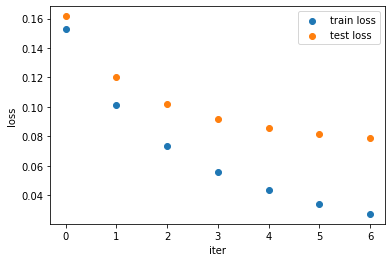

CPU times: user 10min 52s, sys: 2min 14s, total: 13min 6s
Wall time: 4min 3s


,cnn
Accuracy,0.9759
Precision,0.9759
Recall,0.9759


In [23]:
%%time
# TODO n_out_channelは1しか動かない
dnn = ScratchCNNClassifier(epoch = 7, n_padding=0, n_stride= 1, ada_grad = True, n_in_channel = 1, n_out_channel = 1, verbose=False)
dnn.fit(X_train, y_train, X_val, y_val)
pred_y_test = dnn.predict(X_test)
print(pred_y_test.shape)
print(pred_y_test)
print(y_test)
display_loss_graph(dnn)
dnn_tanh_ada_grad_result = eval_accuracy(dnn, X_test, y_test, "cnn")
dnn_tanh_ada_grad_result